In [74]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

otu_table = pd.read_csv('genus_rotated_f_filtered.csv', header=0, index_col=None)

scaler = StandardScaler()
otu_table_scaled = scaler.fit_transform(otu_table)

otu_table_scaled_df = pd.DataFrame(otu_table_scaled, columns=otu_table.columns)


genus_names = otu_table_scaled_df.columns.tolist()
genus_to_idx = {genus: idx for idx, genus in enumerate(genus_names)}


otu_table_scaled_df

,Akkermansia,Alistipes,Bacteroides,Blautia,Clostridium,Collinsella,Coprococcus,Dialister,Dorea,Eubacterium,...,Lachnospira,Odoribacter,Oscillospira,Parabacteroides,Phascolarctobacterium,Prevotella,Roseburia,Ruminococcus,Subdoligranulum,Sutterella
0,-0.252042,-0.280749,0.271185,-0.353872,-0.534273,-0.144031,-0.431156,-0.282647,-0.297151,-0.520141,...,-0.335104,-0.154088,-0.513226,-0.143274,-0.191679,-0.286694,-0.269590,-0.377958,-0.479261,0.274147
1,-0.252042,-0.689663,0.176186,0.571245,-0.410225,0.435834,0.188800,-0.203102,-0.500784,2.653024,...,-0.348625,-0.592377,-0.551495,0.406199,-0.202744,-0.282424,-0.137936,-0.388103,0.088872,-0.399150
2,-0.252042,-0.676542,0.186555,-0.260320,-0.286178,-0.212250,-0.431156,-0.256132,-0.297151,-0.374805,...,-0.578484,-0.329404,-0.535550,-0.298482,-0.202744,-0.285271,-0.162118,-0.323855,-0.357183,-0.399150
3,1.188129,1.536405,-0.248299,0.269803,0.135584,-0.178140,0.158310,-0.163329,-0.195335,0.933217,...,-0.226935,0.196543,1.473549,-0.184306,-0.202744,-0.289541,1.831488,0.545176,1.178186,-0.399150
4,-0.218934,-0.293869,-0.439969,0.238619,-0.029813,-0.212250,-0.166913,-0.282647,0.415565,-0.156802,...,-0.429752,-0.592377,0.032100,0.893232,0.206681,-0.289541,0.410171,-0.117587,-0.361878,-0.399150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314,-0.252042,-0.648115,-0.409864,-0.312293,-0.492923,-0.212250,-0.400667,-0.256132,-0.398968,-0.471696,...,-0.483836,-0.592377,-0.541928,-0.407307,-0.144650,-0.289541,-0.299145,-0.435443,-0.329011,0.243887
315,-0.252042,-0.444752,1.173340,-0.249926,-0.426765,-0.212250,-0.400667,-0.282647,0.110115,-0.495919,...,-0.524400,-0.592377,0.756013,-0.346650,-0.144650,-0.289541,-0.339447,-0.476020,-0.089550,-0.399150
316,-0.218934,-0.206400,-0.505867,0.300986,1.094884,0.265286,-0.034791,0.543739,1.026464,-0.350583,...,-0.497358,-0.373232,0.689044,-0.410875,0.779323,0.096167,-0.312579,0.589134,0.614748,-0.399150
317,-0.103058,-0.689663,-0.710248,-0.270715,-0.095972,0.401725,0.341248,0.919368,-0.195335,0.085425,...,-0.253977,-0.592377,-0.073138,-0.064778,-0.202744,1.989124,-0.387809,-0.222412,-0.418222,-0.399150


In [75]:
class OTUDataset(Dataset):
    def __init__(self, csv, mask_prob=0.15):
        self.data = csv
        self.mask_prob = mask_prob
        self.data_tensor = torch.tensor(self.data.values, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data_tensor[idx]
        masked_sample, mask = self.mask_data(sample)
        return masked_sample, sample, mask

    def mask_data(self, sample):
        mask = torch.bernoulli(torch.full(sample.shape, self.mask_prob)).bool()
        masked_sample = sample.clone()
        masked_sample[mask] = 0  # Using 0 as a placeholder for masked values
        return masked_sample, mask


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class TransformerEncoderModel(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, num_layers):
        super(TransformerEncoderModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model) # include mask + 1
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.fc = nn.Linear(d_model, vocab_size)

    def forward(self, x, return_features=False):
        x= x.long()
        x = self.embedding(x)
        x = self.transformer_encoder(x.permute(1, 0, 2))
        x = x.permute(1, 0, 2)
        # print(x.shape)
        x = x.mean(dim = 1) # 2d, batch ,sequence length, dim 
        # print(x.shape)
        if return_features:
            return x
        x = self.fc(x)
        return x

vocab_size = len(genus_names)
d_model = 64
nhead = 8
num_layers = 6
# print(vocab_size)

model = TransformerEncoderModel(vocab_size, d_model, nhead, num_layers).to(device)
criterion = nn.CrossEntropyLoss()  # 忽略mask token的损失计算
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create a dataset and dataloader
dataset = OTUDataset(otu_table_scaled_df)
# print(dataset)
data_loader = DataLoader(dataset, batch_size=16, shuffle=True)
# for  masked_data, original_data, mask in data_loader:
#     print("masked_data: ",masked_data)
#     print("original_data: ",original_data[mask])
#     print("mask: ",mask)

Epoch 1/32, Loss: -8.48283772468567
Epoch 2/32, Loss: 4.4324562549591064
Epoch 3/32, Loss: -2.1969111442565916
Epoch 4/32, Loss: 12.596948933601379
Epoch 5/32, Loss: -6.918031275272369
Epoch 6/32, Loss: -5.680943703651428
Epoch 7/32, Loss: -0.03083634376525879
Epoch 8/32, Loss: -5.415934491157532
Epoch 9/32, Loss: -11.028694677352906
Epoch 10/32, Loss: 9.854842376708984
Epoch 11/32, Loss: -21.935574579238892
Epoch 12/32, Loss: -6.886506605148315
Epoch 13/32, Loss: 2.154952144622803
Epoch 14/32, Loss: -14.234600925445557
Epoch 15/32, Loss: -31.532829332351685
Epoch 16/32, Loss: -19.83818621635437
Epoch 17/32, Loss: -24.14472041130066
Epoch 18/32, Loss: -34.94503297805786
Epoch 19/32, Loss: -31.29027557373047
Epoch 20/32, Loss: -42.81931600570679
Epoch 21/32, Loss: -63.048363542556764
Epoch 22/32, Loss: -52.40265913009644
Epoch 23/32, Loss: -60.58270559310913
Epoch 24/32, Loss: -64.9733736038208
Epoch 25/32, Loss: -61.82771162986755
Epoch 26/32, Loss: -27.738942193984986
Epoch 27/32, Los

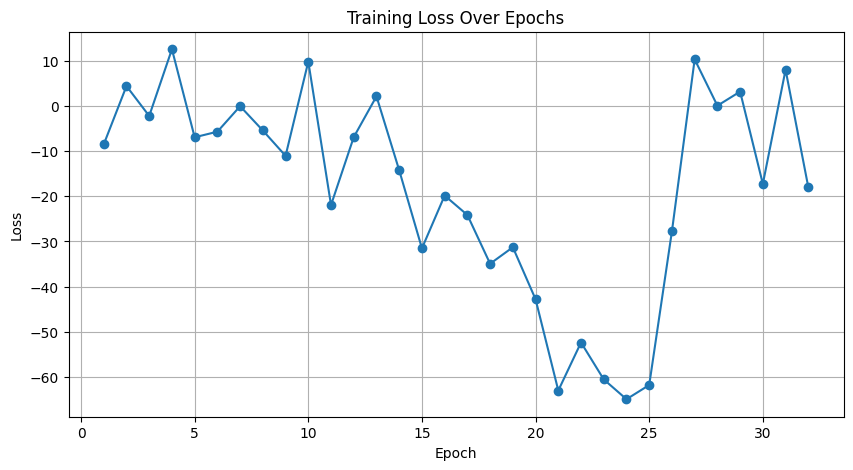

In [76]:
'''
output = torch.tensor([
    [0.1, 0.2, 0.4, 0.1, 0.2],
    [0.3, 0.1, 0.2, 0.3, 0.1],
    [0.2, 0.3, 0.1, 0.2, 0.2],
    [0.3, 0.2, 0.2, 0.1, 0.2],
    [0.2, 0.2, 0.2, 0.2, 0.2],
    [0.1, 0.3, 0.2, 0.3, 0.1]
])
loss = -[log(0.4)+log(0.3)+log(0.2)+log(0.2)+log(0.2)+log(0.3)]
target_data = torch.tensor([2, 3, 4, 1, 2, 3])
'''
def train(model, data_loader, criterion, optimizer, device, epochs=32):
    model.train()
    losses = []
    for epoch in range(epochs):
        total_loss = 0
        for  masked_data, original_data, mask in data_loader:
            masked_data, original_data, mask = masked_data.to(device), original_data.to(device), mask.to(device)
            optimizer.zero_grad()
            outputs = model(masked_data)
            # print("outputs = ",outputs[mask])
            # print("original_data= ",original_data[mask])
            # print("mask = ",mask)
            loss = criterion(outputs[mask], original_data[mask])
            # loss = criterion(output, target_data)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(data_loader)
        losses.append(avg_loss)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss}')
    return losses


losses = train(model, data_loader, criterion, optimizer, device)


torch.save(model.state_dict(), 'pretrained_transformer_encoder_model.pth')


plt.figure(figsize=(10, 5))
plt.plot(range(1, len(losses) + 1), losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()

In [3]:
class EnhancedMLP(nn.Module):
    def __init__(self, pretrained_model, input_size, hidden_size, num_classes):
        super(EnhancedMLP, self).__init__()
        self.pretrained_model = pretrained_model
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        with torch.no_grad():
            x = self.pretrained_model(x.long(), return_features=True)  # 获取编码后的特征
        x = x.mean(dim=1)  # 对序列维度进行平均池化
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [4]:
# 加载预训练的TransformerEncoderModel
pretrained_model = TransformerEncoderModel(vocab_size, d_model, nhead, num_layers)
pretrained_model.load_state_dict(torch.load('pretrained_transformer_encoder_model.pth'))
pretrained_model.to(device)
pretrained_model.eval()  # 设置为评估模式

# EnhancedMLP模型参数
input_size = vocab_size * d_model  # 根据TransformerEncoderModel的输出尺寸调整
hidden_size = 128
num_classes = 10  # 假设有10个类别进行分类

# 初始化EnhancedMLP模型并移动到GPU
enhanced_mlp = EnhancedMLP(pretrained_model, input_size, hidden_size, num_classes).to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = Adam(enhanced_mlp.parameters(), lr=0.0001)
enhanced_mlp

EnhancedMLP(
  (pretrained_model): TransformerEncoderModel(
    (embedding): Embedding(23, 512)
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (fc): Linear(in_features=512, out_features=22, bias=True)
  )
  (fc1): Linear(in_features=11264, out_features=128, bias=True)
  (fc2): Linear(in_feat

In [5]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader

# Read the data into a DataFrame
df = pd.read_csv("NSCLC.csv")
# Filter out columns that contain all zeros
# df = df.loc[:, (NSCLC != 0).any(axis=0)]
f1 = pd.read_csv('genus_rotated_f_filtered.csv')
# print(f1.shape)
# Extract genus-level data
df['Genus'] = df['#NAME'].apply(lambda x: x.split(';g__')[1].split(';')[0] if ';g__' in x else 'Unclassified')

# Select the relevant columns
genus_df = df[['Genus'] + df.columns[1:-1].tolist()]

# Filter out rows with "_unclassified" in the Genus column
NSCLC = genus_df[~genus_df['Genus'].str.contains('_unclassified')]
if 'Genus' in NSCLC.columns:
    NSCLC = NSCLC.groupby('Genus').sum().reset_index()
else:
    NSCLC = NSCLC  # If there is no 'genus' column, use the original data
NSCLC = NSCLC[NSCLC['Genus'].notna() & (NSCLC['Genus'] != '')]
NSCLC = NSCLC.loc[:, (NSCLC != 0).any(axis=0)]
NSCLC.set_index(NSCLC.columns[0], inplace=True)
f2 = NSCLC.transpose()
missing_cols = [col for col in f1.columns if col not in f2.columns]
# Add missing columns to f2 with values set to 0 using pd.concat
f2 = pd.concat([f2, pd.DataFrame(0, index=f2.index, columns=missing_cols)], axis=1)
# Drop columns from f2 that are not in f1
f2 = f2[f1.columns]
# Merge f2 to f1, keeping only the column names
f1 = f2
metadata  = pd.read_csv('metadata_response.csv')
metadata.set_index(metadata.columns[0], inplace=True)
# num_columns = len(merged_table.columns) - 1
merged_table = f1.join(metadata, how='inner')
# merged_table.to_csv("merged_table.csv",index=False)
# merged_table = merged_table.drop(columns=['Best response'])
response = merged_table['Best response']
otu_table_merge = merged_table.drop(columns=['Best response'])
# Drop the first column if it contains sample IDs or unnecessary data
otu_table_merge = otu_table_merge.iloc[:, 1:]

# # Normalize OTU counts by total counts per sample
# normalized_otu_counts = otu_table_merge.div(otu_table_merge.sum(axis=1), axis=0)

# # Optionally, convert to percentages
# normalized_otu_counts *= 100
# 标准化OTU数据
scaler = StandardScaler()
otu_table_scaled = scaler.fit_transform(otu_table_merge)
# normalized_otu_counts = otu_table_merge
# 将标准化后的数据转换回DataFrame
normalized_otu_counts = pd.DataFrame(otu_table_scaled, columns=otu_table_merge.columns)
# Print to verify
# normalized_otu_counts.to_csv("normalized_otu_counts.csv",index=False)
# Create a dictionary to map genus names to unique indices
genus_names = normalized_otu_counts.columns.tolist()
genus_to_idx = {genus: idx for idx, genus in enumerate(genus_names)}
genus_names
genus_to_idx
from sklearn.preprocessing import LabelEncoder

# Assuming 'merged_table' is your DataFrame containing the response and features
encoder = LabelEncoder()
merged_table['Best response'] = encoder.fit_transform(merged_table['Best response'])

# Separate features and target
# features = merged_table.drop('Best response', axis=1)
features = normalized_otu_counts
targets = merged_table['Best response']
targets

ERR2213660     1
ERR2213665     1
ERR2213666     1
ERR2213669     0
ERR2213672     0
              ..
SRR15373067    0
SRR15373089    0
SRR15373078    0
SRR15373012    0
SRR15373143    1
Name: Best response, Length: 417, dtype: int64

In [6]:
class OTUDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        # Ensure data is returned as tensors
        x = torch.tensor(self.features.iloc[idx].values, dtype=torch.float32)
        y = torch.tensor(self.targets.iloc[idx], dtype=torch.long)  # Use torch.long for classification labels
        return x, y
from sklearn.model_selection import train_test_split
# Encode the 'Best response' column
encoder = LabelEncoder()
merged_table['Best response'] = encoder.fit_transform(merged_table['Best response'])

# Split the features and targets into training and testing sets
features_train, features_test, targets_train, targets_test = train_test_split(
    features, targets, test_size=0.2, random_state=42)
# print(features_test)
train_dataset = OTUDataset(features_train, targets_train)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataset = OTUDataset(features_test, targets_test)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [13]:
# Train and evaluate the enhanced model
def train_and_evaluate(model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs=256):
    # Check if GPU is available and move the model to GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    def train_model(model, criterion, optimizer, dataloader, num_epochs):
        model.train()
        for epoch in range(num_epochs):
            total_loss = 0
            for inputs, labels in dataloader:
                # Move inputs and labels to GPU
                inputs, labels = inputs.to(device), labels.to(device)
                
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            if (epoch + 1) % 10 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(dataloader):.4f}')

    def evaluate_model(model, dataloader):
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in dataloader:
                # Move inputs and labels to GPU
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        print(f'Accuracy: {accuracy:.2f}%')

    # Train the model
    train_model(model, criterion, optimizer, train_dataloader,device,num_epochs)
    
    # Evaluate the model
    evaluate_model(model, test_dataloader)



In [17]:
hidden_size = 128
enhanced_model = EnhancedMLP(pretrained_model, d_model, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(enhanced_model.parameters(), lr=0.001)

# Train and evaluate the enhanced model
train_and_evaluate(enhanced_model, train_dataloader, test_dataloader, criterion, optimizer,num_epochs=64)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
